In [1]:
####
# This is just Transfer
####

In [14]:
## Import Modules 
from iminuit import Minuit as imfit
import numpy as np
from numpy import *
import matplotlib.pyplot as plt
import pyymw16
import gammaALPs
from gammaALPs import core
from gammaALPs.bfields import gmf

jansson = gmf.GMF()

# Co-ordinate of sun w.r.t centre of galaxy
d = -8.5

In [15]:
def B_helio(s,l,b):
    
    # Galacto-centric cylindrical co-ordinates in terms of helio-centric co-ordinates
    r = np.sqrt(s**2*cos(b)**2 + d**2 + 2*s*d*cos(l)*cos(b))
    p = arctan2(s*sin(l)*cos(b),(s*cos(l)*cos(b)+d))
    z = s*sin(b)
    
    # Disk, Halo and X field in helio-centric co-ordinates
    B_d = jansson.Bdisk(rho=r, phi=p, z=z) 
    B_h = jansson.Bhalo(rho=r, z=z) 
    B_X = jansson.BX(rho=r,z=z)

    # Components of magnetic field in helio-centric co-ordinates
    B_r = B_d[0][0] + B_h[0][0] + B_X[0][0]
    B_p = B_d[0][1] + B_h[0][1] + B_X[0][1]
    B_z = B_d[0][2] + B_h[0][2] + B_X[0][2]
    
    # Magnetic field in helio-centric co-ordinates    
    B_s = cos(b)*(B_r*cos(l-p)+B_p*sin(l-p)) + B_z*sin(b)
    B_b = sin(b)*(B_r*cos(l-p)+B_p*sin(l-p)) - B_z*cos(b)
    B_l = B_r*sin(p-l) + B_p*cos(p-l)
    
    B_perp = (B_b**2 + B_l**2)**0.5
    Psi = np.arctan2(B_b,B_l)
    
    return B_perp,Psi

In [16]:
# Initialising
#data_drm = loadtxt('/home/adamane/Documents/Axion/Codes/Dat/PSR_J2021+3651.drm')

spec = np.loadtxt('/home/gautam/Documents/Axion/Codes/Dat/psr_spec_dat/L8Y_J1744.5m1134__flux.dat.txt')

s,L,B =  np.array([0.4]),np.array([14.794]),np.array([9.180])
e0 = 1.

step = 0.2
bins = int((s/step)[0])

path = np.flip(np.arange(step,s+step,step),axis=0)

#Initial and Finial States
Rf = np.matrix([[1,0,0],[0,1,0],[0,0,0]])
Ri = 0.5*np.matrix([[1,0,0],[0,1,0],[0,0,0]])

#ne = np.array([0.11 for p in path])   
ne = np.array([pyymw16.calculate_electron_density_lbr(L[0],B[0],p) for p in path])

BP = np.array([B_helio(p,L*np.pi/180,B*np.pi/180) for p in path])
B_perp,psi = np.transpose(BP[:,0])[0],BP[:,1]
psi = np.squeeze(psi)

cp = cos(psi)
sp = sin(psi)


In [17]:
def P_ga(E,m_a,g_ag):
    
    D_ag = 1.52*10**-2*(g_ag*B_perp)
    D_aa = -7.8*10**-2*(m_a**2/E) 
    D_pl = -1.1*10**-7*(ne/E)*1000
    
    # Eigenvalues of mixing matrix
    L1 = D_pl*step
    L2 = 1./2*(D_pl+D_aa-np.sqrt((D_pl-D_aa)**2 + 4*D_ag**2))*step
    L3 = 1./2*(D_pl+D_aa+np.sqrt((D_pl-D_aa)**2 + 4*D_ag**2))*step
    
    alpha = 1./2*arctan2(2.*D_ag,(D_pl-D_aa))
    
    ca = cos(alpha)
    sa = sin(alpha)
    
    ## Computation of probability
    U = np.identity(3)
    el1 = (cos(L1)+1j*sin(L1))
    el2 = (cos(L2)+1j*sin(L2))
    el3 = (cos(L3)+1j*sin(L3))
    
    for i in np.arange(bins): 
        U = np.dot(U,el1[i]*np.array([[cp[i]**2,-sp[i]*cp[i],0],
                                      [-sp[i]*cp[i],sp[i]**2,0],
                                      [0,0,0]]) + 
                     el2[i]*np.array([[sa[i]**2*sp[i]**2,sa[i]**2*sp[i]*cp[i],-sa[i]*ca[i]*sp[i]],
                                      [sa[i]**2*sp[i]*cp[i],sa[i]**2*cp[i]**2,-sa[i]*ca[i]*cp[i]],
                                      [-sa[i]*ca[i]*sp[i],-sa[i]*ca[i]*cp[i],ca[i]**2]]) + 
                     el3[i]*np.array([[ca[i]**2*sp[i]**2,ca[i]**2*sp[i]*cp[i],sa[i]*ca[i]*sp[i]],
                                      [ca[i]**2*sp[i]*cp[i],ca[i]**2*cp[i]**2,sa[i]*ca[i]*cp[i]],
                                      [sa[i]*ca[i]*sp[i],sa[i]*ca[i]*cp[i],sa[i]**2]])) 
    
    Uc = np.transpose(np.conjugate(U))

    return np.real(np.matrix.trace(np.dot(np.dot(np.dot(Rf,U),Ri),Uc))[0,0])
    

In [18]:
s,l,b = s,L[0],B[0]

def dNdE(E0,E,N0,G,G2,Ec,m_a,g_ag):
    
    if(m_a < 0. ): P = np.array([1. for i in range(np.size(E))])
    else : P = np.array([np.real(P_ga(i,m_a,g_ag)) for i in E])
    
    spectrum =  np.array([N0 * 1e-9 *(E[i]/E0)**(-G) * exp(-(E[i]/Ec)**G2)*P[i] for i in range(np.size(E))])
    spectrum = np.array([spectrum[i] * E[i]**2 *1e+6/624150.934 for i in range(np.size(E))]) 

    return spectrum

In [34]:
sigma = np.sqrt(spec[:,2]**2 + (0.024*spec[:,1])**2)
def sq(N0,G,G2,Ec,m_a,g_ag,E0):
    dnde = dNdE(E0,spec[:,0]/1000,N0,G,G2,Ec,m_a,g_ag)
    chi = (dnde-spec[:,1])/sigma
    s2 = sum(chi**2)
    return s2     

In [35]:
m1 = imfit(sq, N0 = 0.03 , G = 0.54 , G2 = 1 , Ec = 0.5, 
          m_a = -1,  g_ag = -1 , E0 = e0 ,
          error_N0 = 10. , error_G = 10. , fix_G2 = 10. , error_Ec = 1. , fix_E0 = 0.09,
          fix_m_a = 5. , fix_g_ag = 5. , errordef = 1 , limit_G=(0.,10))
m1.migrad(ncall=1600,resume=True)

------------------------------------------------------------------
| FCN = 18.44                   |     Ncalls=174 (174 total)     |
| EDM = 9.98E-07 (Goal: 1E-05)  |            up = 1.0            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
------------------------------------------------------------------------------------------
|   | Name |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
------------------------------------------------------------------------------------------
| 0 | N0   |  2.18E-2  |  0.29E-2  |            |            |         |         |       |
| 1 | G    |   0.74    |   0.16    |            |            |    0    |   10    |       |
| 2 | G2   |    1.0    |    1.0    |            |            |         |         |  yes  |
| 3 | Ec   |   1.01    |   0.12    |            |            |         |         |       |
| 4 | m_a  |   -1.0    |    1.0    |            |            |         |         |  yes  |
| 5 | g_ag |   -1.0    |    1.0    |            |            |         |         |  yes  |
| 6 | E0   |    1.0    |    1.0    |            |            |         |         |  yes  |
------------------------------------------------------------------------------------------

In [125]:
F = m1.fval

In [126]:
res = np.array([])
i = 0
for gALP in np.linspace(10,210,21):
    for mALP in np.linspace(2,20,19):
        m = imfit(sq, N0 = m1.values["N0"] , G2 = 0.54 , G = m1.values["G"] , Ec = m1.values["Ec"], 
          m_a = mALP, g_ag = gALP , E0 = e0 ,
          error_N0 = 10. , error_G = 10. , fix_G2 = 10. , error_Ec = 1. , fix_E0 = 1.,
          fix_m_a = 5. , fix_g_ag = 5. , errordef = 1 , limit_G=(0.,10))
        m.migrad(ncall=100,resume=True)
        res = np.append(res,[m.values["m_a"],m.values["g_ag"],m.fval])
        if m.fval < F : print i,m.fval,mALP,gALP,m.edm
        i+=1

9 17.1100701356 11.0 10.0 4.54863266272e-08
10 17.0888196975 12.0 10.0 4.94963243091e-08
11 17.0768077717 13.0 10.0 4.64790347851e-08
12 17.0766201853 14.0 10.0 0.000194093145887
13 17.0861546315 15.0 10.0 0.000157151868842
14 17.0999637927 16.0 10.0 0.00011802350281
15 17.1120286896 17.0 10.0 8.48194467239e-05
18 17.1144092788 20.0 10.0 3.7054823457e-05
28 17.0959928102 11.0 20.0 1.88269890675e-05
29 17.0112361455 12.0 20.0 1.47319889124e-05
30 16.9636341748 13.0 20.0 1.6173648081e-05
31 16.9624296795 14.0 20.0 9.75667072818e-06
32 17.0007528865 15.0 20.0 6.24117178829e-06
33 17.0559746012 16.0 20.0 3.68260023854e-06
34 17.1041635872 17.0 20.0 1.65424070435e-07
37 17.1133927253 20.0 20.0 8.91412848142e-08
47 17.0724735511 11.0 30.0 1.6471561319e-07
48 16.8827322141 12.0 30.0 1.48676331799e-07
49 16.7772858101 13.0 30.0 1.45549054822e-07
50 16.7759084549 14.0 30.0 0.000116072453831
51 16.8622552085 15.0 30.0 8.01693056281e-05
52 16.9858442384 16.0 30.0 4.37371299639e-05
53 17.093507966

In [127]:
m = imfit(sq, N0 = m.values["N0"] , G2 = 0.54 , G = m.values["G"] , Ec = m.values["Ec"], 
  m_a = 13, g_ag = 210 , E0 = e0 ,
  error_N0 = 10. , error_G = 10. , fix_G2 = 10. , error_Ec = 1. , fix_E0 = 1.,
  error_m_a = 1. , error_g_ag = 1. , errordef = 1 , limit_G=(0.,10) , limit_g_ag = (0,1000))
m.migrad(ncall=1500,resume=True)

------------------------------------------------------------------
| FCN = 9.023                   |     Ncalls=247 (247 total)     |
| EDM = 3.3E-05 (Goal: 1E-05)   |            up = 1.0            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
------------------------------------------------------------------------------------------
|   | Name |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
------------------------------------------------------------------------------------------
| 0 | N0   |   0.186   |   0.028   |            |            |         |         |       |
| 1 | G    | 0.000E-1  | 1.393E-1  |            |            |    0    |   10    |       |
| 2 | G2   |    0.5    |    1.0    |            |            |         |         |  yes  |
| 3 | Ec   |   0.126   |   0.011   |            |            |         |         |       |
| 4 | m_a  |   12.2    |    0.9    |            |            |         |         |       |
| 5 | g_ag |    260    |    80     |            |            |    0    |  1000   |       |
| 6 | E0   |    1.0    |    1.0    |            |            |         |         |  yes  |
------------------------------------------------------------------------------------------

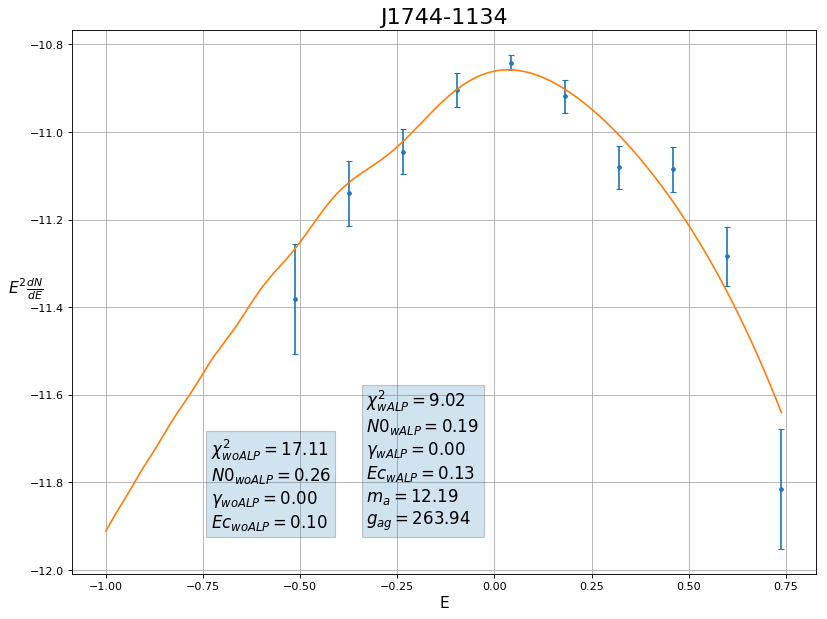

In [132]:
N0,G,G2,Ec,m_a,g_ag,E0 = m.np_values()

fig=plt.figure(figsize=(12, 9), dpi= 80)
ax = fig.gca()

#ax.set_xticks(np.arange(-1, 2, 1))
#ax.set_yticks(np.arange(-13, -9.5, 1))
#plt.xlim(-1.,2.)
#plt.ylim(-13,-9.5)

plt.scatter(np.log10(spec[:,0]/1000.),np.log10(spec[:,1]),s=10)
plt.grid(True)

sigma = np.sqrt(spec[:,2]**2 + (0.024*spec[:,1])**2)
plt.errorbar(np.log10(spec[:,0]/1000.),np.log10(spec[:,1]),yerr=np.log10(1+sigma/spec[:,1]), linestyle="None",capsize=2.5)

E = logspace(log10(100), log10(max(spec[:,0])), 200)*1e-3 # to generalise

woALP = dNdE(E0,E,N0,G,G2,Ec,m_a,g_ag)

plt.plot(np.log10(E),np.log10(woALP))

textstr_woALP = '\n'.join((
    r'$\chi^{2}_{woALP}=%.2f$' % (m1.fval),
    r'$N0_{woALP}=%.2f$' % (m1.values['N0']),
    r'$\gamma_{woALP}=%.2f$' % (m1.values['G']),
    r'$Ec_{woALP}=%.2f$' % (m1.values['Ec'])))
    
textstr_wALP = '\n'.join((
    r'$\chi^{2}_{wALP}=%.2f$' % (m.fval),
    r'$N0_{wALP}=%.2f$' % (m.values['N0']),
    r'$\gamma_{wALP}=%.2f$' % (m.values['G']),
    r'$Ec_{wALP}=%.2f$' % (m.values['Ec']),
    r'$m_a=%.2f$' % (m.values['m_a']),
    r'$g_{ag}=%.2f$' % (m.values['g_ag'])))

plt.xlabel('E',fontsize=14)
plt.ylabel('$E^{2} \\frac{dN}{dE}$',rotation=0,fontsize=14)

plt.text(-0.73,-11.9,textstr_woALP, bbox=dict( alpha=0.2),fontsize=15)
plt.text(-0.33,-11.9,textstr_wALP, bbox=dict( alpha=0.2),fontsize=15)

plt.title('J1744-1134',fontsize=20)
plt.savefig('Fit_J1744-1134.png')
np.savetxt('pspace_J1744-1134',res)